In [1]:
import polars as pl

PATH = r"C:\Users\kelvi\Downloads\gxggyfauz48qbaqx.csv"

lf = (
    pl.scan_csv(PATH)
      .with_columns(
          pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False, exact=False),
          pl.col("PRC").cast(pl.Float64, strict=False),
          pl.col("SHROUT").cast(pl.Float64, strict=False),
          pl.col("RET").cast(pl.Float64, strict=False),
          pl.col("DLRET").cast(pl.Float64, strict=False),
          pl.col("VOL").cast(pl.Float64, strict=False),
      )
      .filter(pl.col("date").is_not_null())
)


liq_window = lf.filter(pl.col("date").is_between(pl.date(1984,7,1), pl.date(1985,12,31)))

liq_base = (
    liq_window
    .select(["date","PERMNO","PRC","RET","VOL"])
    .group_by(["PERMNO","date"])
    .agg([
        pl.col("PRC").last().alias("PRC"),
        pl.col("RET").last().alias("RET"),
        pl.col("VOL").last().alias("VOL"),
    ])
    .sort(["PERMNO","date"])
    .with_columns(
        ((pl.col("PRC").abs() / pl.col("PRC").abs().shift(1).over("PERMNO")) - 1.0)
        .alias("RET_from_PRC")
    )
    .with_columns(
        pl.coalesce([pl.col("RET"), pl.col("RET_from_PRC")]).alias("RET_base")
    )
)

liq_metrics = (
    liq_base
    .with_columns([
        (pl.col("VOL").fill_null(0) > 0).alias("traded"),
        (pl.col("RET_base").abs() > 0).alias("nonzero_ret"),
        (pl.col("PRC").abs() * pl.col("VOL")).alias("DOLLAR_VOL"),
    ])
    .group_by("PERMNO")
    .agg([
        pl.col("DOLLAR_VOL").median().alias("med_dollar_vol"),
        pl.col("traded").mean().alias("frac_traded"),
        pl.col("nonzero_ret").mean().alias("frac_nonzero_ret"),
    ])
)

THRESH_DV = 5_000_000.0   # $5m median dollar volume 
THRESH_TR = 0.90          # ≥90% of days traded
THRESH_NR = 0.80          # ≥80% non-zero return days

eligible = (
    liq_metrics
    .filter(
        (pl.col("med_dollar_vol") >= THRESH_DV) &
        (pl.col("frac_traded")    >= THRESH_TR) &
        (pl.col("frac_nonzero_ret") >= THRESH_NR)
    )
    .select("PERMNO")
)

# -----------------------------
# 2) Universe snapshot at 1985 YE (last obs in 1985) from eligible names only
#    mktcap = |PRC| * SHROUT * 1000  
# -----------------------------
lf_1985 = lf.filter(pl.col("date").is_between(pl.date(1985,1,1), pl.date(1985,12,31)))

universe_df = (
    lf_1985
    .join(eligible, on="PERMNO", how="inner")
    .select(["PERMNO","date","PRC","SHROUT"])
    .with_columns((pl.col("PRC").abs() * pl.col("SHROUT") * 1_000.0).alias("mktcap"))
    .group_by("PERMNO")
    .agg(pl.struct(["date","mktcap"]).sort_by("date").last().alias("row"))
    .with_columns(pl.col("row").struct.field("mktcap").alias("mktcap_1985"))
    .select(["PERMNO","mktcap_1985"])
    .sort("mktcap_1985", descending=True)
    .limit(200)
    .collect()
)

UNIVERSE = universe_df["PERMNO"].to_list()
print(f"Static universe (1985 YE, liquidity-screened): {len(UNIVERSE)} names")


lf_uni = (
    lf.filter(pl.col("PERMNO").is_in(UNIVERSE))
      .filter(pl.col("date") >= pl.date(1985,1,1))
      .select(["date","PERMNO","PRC","RET","DLRET","VOL","TICKER"])
      .group_by(["PERMNO","date"])
      .agg([
          pl.col("PRC").last().alias("PRC"),
          pl.col("RET").last().alias("RET"),
          pl.col("DLRET").last().alias("DLRET"),
          pl.col("VOL").last().alias("VOL"),
          pl.col("TICKER").last().alias("TICKER"),
      ])
      .sort(["PERMNO","date"])
      .with_columns(
          ((pl.col("PRC").abs() / pl.col("PRC").abs().shift(1).over("PERMNO")) - 1.0)
          .alias("RET_from_PRC")
      )
      .with_columns(pl.coalesce([pl.col("RET"), pl.col("RET_from_PRC")]).alias("RET_base"))
      .with_columns(
          pl.when(pl.col("DLRET").is_not_null())
            .then((1 + pl.col("RET_base")) * (1 + pl.col("DLRET")) - 1.0)
            .otherwise(pl.col("RET_base"))
            .alias("RET_DAILY")
      )
)


head_long = (
    lf_uni.select(["date","PERMNO","TICKER","RET","RET_from_PRC","DLRET","RET_DAILY","VOL"])
          .sort(["date","PERMNO"])
          .limit(12)
          .collect()
)
print("\n=== HEAD (long panel, screened universe) ===")
print(head_long)

per_date = (
    lf_uni.with_columns((pl.col("RET_DAILY").abs() < 1e-15).alias("is_zero"))
          .group_by("date")
          .agg([
              pl.len().alias("n_names"),
              pl.col("is_zero").sum().alias("n_zero"),
              (pl.col("is_zero") & (pl.col("VOL").fill_null(0) == 0)).sum().alias("n_zero_vol0"),
          ])
          .with_columns((pl.col("n_zero") / pl.col("n_names")).alias("pct_zero"))
          .sort("date")
          .limit(10)
          .collect()
)
print("\n=== First 10 dates: share of zeros (screened universe) ===")
print(per_date)


first5_dates = (
    lf_uni.select("date").unique().sort("date").limit(5).collect()["date"].to_list()
)
wide_preview = (
    lf_uni.filter(pl.col("date").is_in(first5_dates))
          .select(["date","PERMNO","RET_DAILY"])
          .collect()
          .pivot(index="date", on="PERMNO", values="RET_DAILY")
          .sort("date")
)
print("\n=== WIDE preview (PERMNO columns) ===")
print(wide_preview)


Static universe (1985 YE, liquidity-screened): 163 names

=== HEAD (long panel, screened universe) ===
shape: (12, 8)
┌────────────┬────────┬────────┬───────────┬──────────────┬───────┬───────────┬──────────┐
│ date       ┆ PERMNO ┆ TICKER ┆ RET       ┆ RET_from_PRC ┆ DLRET ┆ RET_DAILY ┆ VOL      │
│ ---        ┆ ---    ┆ ---    ┆ ---       ┆ ---          ┆ ---   ┆ ---       ┆ ---      │
│ date       ┆ i64    ┆ str    ┆ f64       ┆ f64          ┆ f64   ┆ f64       ┆ f64      │
╞════════════╪════════╪════════╪═══════════╪══════════════╪═══════╪═══════════╪══════════╡
│ 1985-01-02 ┆ 10145  ┆ ALD    ┆ -0.014493 ┆ null         ┆ null  ┆ -0.014493 ┆ 168500.0 │
│ 1985-01-02 ┆ 10233  ┆ ABC    ┆ -0.011881 ┆ null         ┆ null  ┆ -0.011881 ┆ 81200.0  │
│ 1985-01-02 ┆ 10401  ┆ T      ┆ -0.012821 ┆ null         ┆ null  ┆ -0.012821 ┆ 1.0446e6 │
│ 1985-01-02 ┆ 10604  ┆ ARC    ┆ -0.002833 ┆ null         ┆ null  ┆ -0.002833 ┆ 295900.0 │
│ 1985-01-02 ┆ 10890  ┆ BGH    ┆ -0.011013 ┆ null         ┆ nul

In [17]:
import polars as pl
from pathlib import Path

OUT_DIR = Path(r"C:\Users\kelvi\Downloads") 
LONG_PARQUET = OUT_DIR / "ret_daily_top200_long.parquet"

lf_uni.select(["date","PERMNO","TICKER","RET_DAILY"]).sink_parquet(str(LONG_PARQUET))

ret_long = pl.read_parquet(str(LONG_PARQUET))

ret_wide_permno = (
    ret_long
    .select(["date","PERMNO","RET_DAILY"])
    .pivot(index="date", on="PERMNO", values="RET_DAILY", aggregate_function="first")
    .sort("date")
)
print("PERMNO-wide shape:", ret_wide_permno.shape)
print(ret_wide_permno.head(5))

ticker_counts = (
    ret_long
    .group_by(["PERMNO","TICKER"])
    .agg(pl.len().alias("n"))
    .sort(["PERMNO","n"], descending=[False, True]) 
)

primary_labels = (
    ticker_counts
    .group_by("PERMNO")
    .agg(pl.col("TICKER").first().alias("label"))  
)

permno_to_label = dict(
    zip(primary_labels["PERMNO"].to_list(), primary_labels["label"].to_list())
)

rename_map = {}
for c in ret_wide_permno.columns:
    if c == "date":
        continue
    try:
        p = int(c) 
    except ValueError:
        continue
    lab = permno_to_label.get(p)
    if lab is None or lab == "":
        lab = f"P{p}"
    rename_map[c] = f"{lab}__{p}"

ret_wide_ticker = ret_wide_permno.rename(rename_map)

print("Ticker-wide shape:", ret_wide_ticker.shape)
print(ret_wide_ticker.head(5))


check = (
    ret_wide_permno
    .with_columns([
        # row-wise counts across all return columns (exclude the date col)
        pl.sum_horizontal(pl.all().exclude("date").is_null()).alias("n_null"),
        pl.sum_horizontal(pl.all().exclude("date") == 0.0).alias("n_zero"),
        pl.lit(ret_wide_permno.width - 1).alias("n_cols"),  # number of return columns
    ])
    .select([
        "date",
        (pl.col("n_null") / pl.col("n_cols")).alias("frac_null"),
        (pl.col("n_zero") / pl.col("n_cols")).alias("frac_zero"),
    ])
    .head(10)
)
print(check)


PERMNO-wide shape: (10082, 164)
shape: (5, 164)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────┬───────────┐
│ date       ┆ 10145     ┆ 10233     ┆ 10401     ┆ … ┆ 66122     ┆ 66800     ┆ 68419 ┆ 74617     │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---   ┆ ---       │
│ date       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64   ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════╪═══════════╡
│ 1985-01-02 ┆ -0.014493 ┆ -0.011881 ┆ -0.012821 ┆ … ┆ 0.0       ┆ -0.011009 ┆ null  ┆ -0.025641 │
│ 1985-01-03 ┆ 0.0       ┆ -0.012024 ┆ 0.012987  ┆ … ┆ -0.001773 ┆ -0.009276 ┆ null  ┆ -0.039474 │
│ 1985-01-04 ┆ 0.003676  ┆ -0.006085 ┆ 0.00641   ┆ … ┆ 0.0       ┆ -0.007491 ┆ null  ┆ 0.006849  │
│ 1985-01-07 ┆ 0.010989  ┆ -0.016327 ┆ 0.012739  ┆ … ┆ 0.001776  ┆ -0.011321 ┆ null  ┆ 0.0       │
│ 1985-01-08 ┆ 0.0       ┆ 0.033195  ┆ 0.0       ┆ … ┆ -0.005

In [2]:
OUT_DIR = r"C:\Users\kelvi\Downloads"

universe_path = fr"{OUT_DIR}\universe_1985_liq_top200.csv"
universe_df.write_csv(universe_path)
print(f"Saved universe list → {universe_path} (n={universe_df.height})")

ret_long_all = (
    lf_uni
    .select(["date","PERMNO","RET_DAILY"])
    .filter(pl.col("RET_DAILY").is_not_null())
    .sort(["date","PERMNO"])
    .collect(engine="in-memory")
)
long_csv_path = fr"{OUT_DIR}\ret_daily_top200_long.csv"
ret_long_all.write_csv(long_csv_path)
print(f"Saved long daily returns → {long_csv_path} (rows={ret_long_all.height})")


ret_wide_full = (
    ret_long_all
    .with_columns(pl.col("PERMNO").cast(pl.Utf8))  # ensure string column names
    .pivot(index="date", on="PERMNO", values="RET_DAILY")
    .sort("date")
)
wide_csv_path = fr"{OUT_DIR}\ret_daily_top200_wide_permno.csv"
ret_wide_full.write_csv(wide_csv_path)
print(f"Saved wide daily returns (CSV) → {wide_csv_path} (shape={ret_wide_full.shape})")

wide_parq_path = fr"{OUT_DIR}\ret_daily_top200_wide_permno.parquet"
ret_wide_full.write_parquet(wide_parq_path)
print(f"Saved wide daily returns (Parquet) → {wide_parq_path}")


Saved universe list → C:\Users\kelvi\Downloads\universe_1985_liq_top200.csv (n=163)
Saved long daily returns → C:\Users\kelvi\Downloads\ret_daily_top200_long.csv (rows=974325)
Saved wide daily returns (CSV) → C:\Users\kelvi\Downloads\ret_daily_top200_wide_permno.csv (shape=(10080, 164))
Saved wide daily returns (Parquet) → C:\Users\kelvi\Downloads\ret_daily_top200_wide_permno.parquet


In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

WIDE_PARQ_PATH  = r"C:\Users\kelvi\Downloads\ret_daily_top200_wide_permno.parquet"
WIDE_CSV_PATH   = r"C:\Users\kelvi\Downloads\ret_daily_top200_wide_permno.csv"

STATE_VAR_PATH  = r"C:\Users\kelvi\Documents\Berkeley\Term 2\Projects\Regimes\Data\Original Reproduction\state_z_america.xlsx"

EXCLUDE_M    = 36
BT_START     = "1985-01"    
BT_END       = "2024-12"   

def load_daily_wide():
    try:
        df = pl.read_parquet(WIDE_PARQ_PATH)
    except Exception:
        df = pl.read_csv(WIDE_CSV_PATH, try_parse_dates=True)
    # Ensure date type & sort
    if df.schema.get("date") != pl.Date:
        df = df.with_columns(pl.col("date").cast(pl.Date, strict=False))
    df = df.sort("date")
    # Sanity: all non-date columns numeric
    others = [c for c in df.columns if c != "date"]
    df = df.with_columns([pl.col(c).cast(pl.Float64, strict=False) for c in others])
    return df

ret_wide = load_daily_wide()
print("Daily wide shape:", ret_wide.shape)

Daily wide shape: (10080, 164)


In [2]:

ret_long = (
    ret_wide
    .unpivot(index="date", on=[c for c in ret_wide.columns if c != "date"],
             variable_name="PERMNO", value_name="RET_DAILY")
    .drop_nulls(["RET_DAILY"])                      # we only need observed daily returns
    .sort(["PERMNO","date"])
)

ret_m_long = (
    ret_long
    .group_by_dynamic(index_column="date", every="1mo", group_by="PERMNO", closed="right")
    .agg(((1 + pl.col("RET_DAILY")).product() - 1.0).alias("RET_M"))
    .with_columns(pl.col("date").dt.strftime("%Y-%m").alias("month"))
    .select(["month","PERMNO","RET_M"])
    .sort(["PERMNO","month"])
)

ret_m_wide = (
    ret_m_long
    .pivot(index="month", on="PERMNO", values="RET_M")
    .sort("month")
)

retm_months = ret_m_wide["month"].to_list()
print("Monthly grid span:", retm_months[0], "→", retm_months[-1], "| n_months:", len(retm_months))

Monthly grid span: 1985-01 → 2024-12 | n_months: 480


In [3]:

from pathlib import Path
import polars as pl

def _first_df_from_excel(obj):
    if isinstance(obj, dict):
        key = sorted(obj.keys())[0]
        return obj[key]
    return obj 

def load_state_var(path: str) -> pl.DataFrame:
    p = Path(path)
    ext = p.suffix.lower()

    if ext == ".parquet":
        sv = pl.read_parquet(path)
    elif ext in (".xlsx", ".xls"):
        try:
            sv = pl.read_excel(path, sheet_id=0)
        except TypeError:
            sv = pl.read_excel(path, sheet=0)
        sv = _first_df_from_excel(sv)
    else:
        try:
            sv = pl.read_csv(path)
        except Exception:
            sv = pl.read_csv(path, encoding="utf8-lossy")

    cols_lower = {c.lower(): c for c in sv.columns}
    month_col = cols_lower.get("month", next(iter(sv.columns)))

    m = pl.col(month_col).cast(pl.Utf8, strict=False)
    sv = (
        sv.with_columns(m.alias("_m_raw"))
          .with_columns(
              pl.when(pl.col("_m_raw").str.contains(r"^\d{4}-\d{2}$"))     
                .then(pl.col("_m_raw"))
              .when(pl.col("_m_raw").str.contains(r"^\d{4}/\d{2}$"))        
                .then(pl.col("_m_raw").str.replace("/", "-"))
              .when(pl.col("_m_raw").str.contains(r"^\d{6}$"))              
                .then(pl.format("{}-{}", pl.col("_m_raw").str.slice(0,4), pl.col("_m_raw").str.slice(4,2)))
              .otherwise(pl.col("_m_raw"))                                 
              .alias("month")
          )
          .drop(["_m_raw"] + ([month_col] if month_col != "month" else []))
    )

    numeric_types = {
        pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8,
        pl.UInt64, pl.UInt32, pl.UInt16, pl.UInt8
    }
    feature_cols = [c for c, t in sv.schema.items() if c != "month" and t in numeric_types]
    if not feature_cols:
        feature_cols = [c for c in sv.columns if c != "month"]
        sv = sv.with_columns([pl.col(c).cast(pl.Float64, strict=False) for c in feature_cols])

    sv = (
        sv.select(["month"] + feature_cols)
          .drop_nulls(["month"])
          .unique(subset=["month"], keep="last")
          .sort("month")
    )
    return sv

state_var = load_state_var(STATE_VAR_PATH)

months_macro = set(state_var["month"].to_list())
months_retm  = set(ret_m_wide["month"].to_list())
months_keep  = sorted([m for m in (months_macro & months_retm) if (m >= BT_START and m <= BT_END)])
if not months_keep:
    raise ValueError("No overlapping months between macro and returns in the requested window.")

state_var  = state_var.filter(pl.col("month").is_in(months_keep)).sort("month")
ret_m_wide = ret_m_wide.filter(pl.col("month").is_in(months_keep)).sort("month")

print("Aligned months:", months_keep[0], "→", months_keep[-1], "| n=", len(months_keep))
print("state_var type:", type(state_var), "ret_m_wide type:", type(ret_m_wide))

Aligned months: 1985-01 → 2024-12 | n= 461
state_var type: <class 'polars.dataframe.frame.DataFrame'> ret_m_wide type: <class 'polars.dataframe.frame.DataFrame'>


C:\Users\kelvi\AppData\Local\Temp\ipykernel_34588\1915363832.py:153: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(sub, axis=0)
C:\Users\kelvi\AppData\Local\Temp\ipykernel_34588\1915363832.py:188: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  q_df = {q: pl.DataFrame(returns_by_q[q], schema=["date","ret"]).sort("date") for q in range(1,6)}



=== Summary (daily, full sample; equal-weight, no factor neutrality) ===
            Ann. Return  Ann. Vol  Ann. Sharpe  Corr vs LO  Max DD  N days
Q1               0.0969    0.1466       0.7046      0.9508 -0.5391  8890.0
Q2               0.0711    0.1480       0.5381      0.9194 -0.5629  8890.0
Q3               0.0854    0.1364       0.6689      0.9082 -0.4464  8890.0
Q4               0.0801    0.1460       0.6011      0.8855 -0.4769  8890.0
Q5               0.0619    0.1322       0.5209      0.8403 -0.4498  8890.0
LS (Q1−Q5)       0.0311    0.0870       0.3959      0.3255 -0.3130  8890.0
Long-only        0.1278    0.1837       0.7469         NaN -0.6068  8890.0


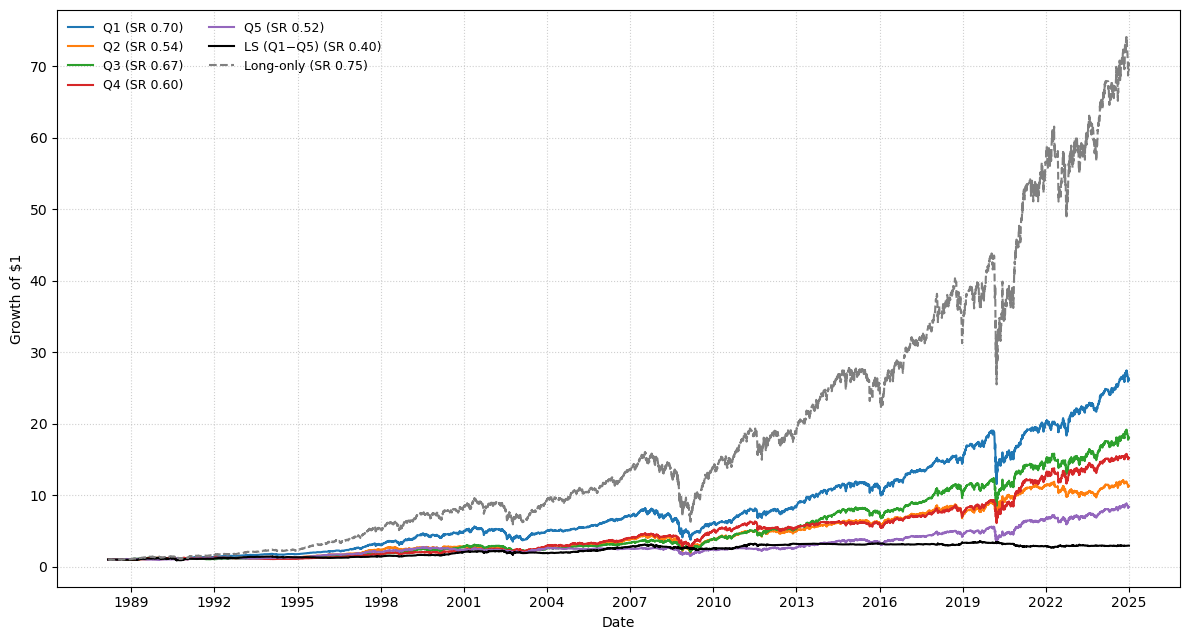

In [4]:
# ============================================================
# Simple similarity backtest 
# ============================================================
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


EXCLUDE_M  = 36                 
BT_START   = "1985-01"
BT_END     = "2024-12"


if "month" not in ret_wide.columns:
    ret_wide_m = ret_wide.with_columns(pl.col("date").dt.strftime("%Y-%m").alias("month"))
else:
    ret_wide_m = ret_wide
daily_cols = [c for c in ret_wide_m.columns if c not in ("date","month")]


ret_long = (
    ret_wide_m
      .unpivot(index="date", on=daily_cols, variable_name="PERMNO", value_name="RET_DAILY")
      .drop_nulls(["RET_DAILY"])
      .sort(["PERMNO","date"])
)

ret_m_long = (
    ret_long
      .group_by_dynamic(index_column="date", every="1mo", group_by="PERMNO", closed="right")
      .agg(((1 + pl.col("RET_DAILY")).product() - 1.0).alias("RET_M"))
      .with_columns(pl.col("date").dt.strftime("%Y-%m").alias("month"))
      .select(["month","PERMNO","RET_M"])
      .sort(["PERMNO","month"])
)

ret_m_wide = (
    ret_m_long
      .pivot(index="month", on="PERMNO", values="RET_M")
      .sort("month")
)


months_macro = set(state_var["month"].to_list())
months_retm  = set(ret_m_wide["month"].to_list())
months_keep  = sorted([m for m in (months_macro & months_retm) if (m >= BT_START and m <= BT_END)])
if not months_keep:
    raise RuntimeError("No overlapping months between macro and returns in the requested window.")

state_var  = state_var.filter(pl.col("month").is_in(months_keep)).sort("month")
ret_m_wide = ret_m_wide.filter(pl.col("month").is_in(months_keep)).sort("month")
months_bt  = months_keep[:]


macro_cols    = [c for c in state_var.columns if c != "month"]
macro_months  = state_var["month"].to_list()
macro_mat     = state_var.select(macro_cols).to_numpy()            
month_to_row  = {m: i for i, m in enumerate(macro_months)}

retm_cols     = [c for c in ret_m_wide.columns if c != "month"]     
retm_months   = ret_m_wide["month"].to_list()
retm_mat      = ret_m_wide.select(retm_cols).to_numpy()              
col_to_idx    = {c: i for i, c in enumerate(retm_cols)}


def ym_to_int(ym: str) -> int:
    y, m = ym.split("-"); return int(y) * 12 + int(m)

def int_to_ym(k: int) -> str:
    y, m = divmod(k - 1, 12); return f"{y+1:04d}-{m+1:02d}"

def month_plus(ym: str, n: int) -> str:
    return int_to_ym(ym_to_int(ym) + n)

def candidate_pool(target_ym: str, exclude_m: int) -> list[str]:
    cut = ym_to_int(target_ym) - exclude_m
    return [m for m in macro_months if ym_to_int(m) < cut]

def find_similar_months(target_ym: str, bottom_pct: float = 1.0) -> list[str]:
    if target_ym not in month_to_row:
        prior = [m for m in macro_months if ym_to_int(m) < ym_to_int(target_ym)]
        if not prior:
            return []
        target_ym = prior[-1]

    pool = candidate_pool(target_ym, EXCLUDE_M)
    if not pool:
        return []

    idx  = np.fromiter((month_to_row[m] for m in pool), dtype=int)
    X    = macro_mat[idx]                              
    x    = macro_mat[month_to_row[target_ym]][None, :]  
    d    = np.sqrt(np.maximum(((X - x) ** 2).sum(axis=1), 0.0))
    order = np.argsort(d)
    sorted_pool = [pool[i] for i in order]

    if bottom_pct >= 1.0:
        return sorted_pool
    n = max(int(np.floor(bottom_pct * len(sorted_pool))), 1)
    return sorted_pool[:n]

def quintile_members(target_ym: str) -> dict[int, np.ndarray]:
    months = np.array(find_similar_months(target_ym, bottom_pct=1.0))
    if months.size == 0:
        return {q: np.array([]) for q in range(1, 6)}
    n = months.size
    k20 = int(0.20 * n)
    if k20 == 0:
        return {1: np.array([]), 2: np.array([]), 3: months, 4: np.array([]), 5: np.array([])}
    q1 = months[:k20]
    q5 = months[-k20:]
    mid = months[k20:-k20]
    if mid.size >= 3:
        q2, q3, q4 = np.array_split(mid, 3)
    else:
        q2, q3, q4 = np.array([]), mid, np.array([])
    return {1: q1, 2: q2, 3: q3, 4: q4, 5: q5}

def signal_for_quintile(target_ym: str, quintile: int) -> dict[str, int]:
    
    months = quintile_members(target_ym)[quintile]
    if months.size == 0:
        return {c: 0 for c in daily_cols}

    fwd = [month_plus(m, 1) for m in months if m in retm_months or month_plus(m,1) in retm_months]
    fwd = [m for m in fwd if m in retm_months]
    if not fwd:
        return {c: 0 for c in daily_cols}

    rows = np.fromiter((retm_months.index(m) for m in fwd), dtype=int)
    sub  = retm_mat[rows, :]                    
    with np.errstate(all='ignore'):
        mu = np.nanmean(sub, axis=0)
    mu  = np.where(np.isfinite(mu), mu, 0.0)
    sgn = np.sign(mu).astype(int)

    out = {}
    for c in daily_cols:
        j = col_to_idx.get(c, None)
        out[c] = int(sgn[j]) if j is not None else 0
    return out


returns_by_q = {q: [] for q in range(1, 6)}

for i in range(0, len(months_bt) - 1):
    cur, nxt = months_bt[i], months_bt[i+1]

    rows_tp1 = ret_wide_m.filter(pl.col("month") == nxt)
    if rows_tp1.height == 0:
        continue

    cols  = [c for c in rows_tp1.columns if c not in ("date","month")]
    M     = rows_tp1.select(cols).to_numpy()            
    dates = rows_tp1["date"].to_list()

    for q in range(1, 6):
        sig   = signal_for_quintile(cur, q)            
        s_vec = np.array([sig.get(c, 0) for c in cols], dtype=float)  
        with np.errstate(all='ignore'):
            dret = np.nanmean(M * s_vec[None, :], axis=1)            
        returns_by_q[q].extend(zip(dates, dret.tolist()))

q_df = {q: pl.DataFrame(returns_by_q[q], schema=["date","ret"]).sort("date") for q in range(1,6)}
common_dates = sorted(set.intersection(*[set(q_df[q]["date"].to_list()) for q in range(1,6)]) if all(q_df[q].height for q in range(1,6)) else set())
for q in range(1,6):
    q_df[q] = q_df[q].filter(pl.col("date").is_in(common_dates)).sort("date")

# long–short
ls_df = (
    q_df[1].join(q_df[5], on="date", how="inner", suffix="_q5")
           .with_columns((pl.col("ret") - pl.col("ret_q5")).alias("ret_ls"))
           .select(["date","ret_ls"])
           .sort("date")
)


first_trade_month = None
for i in range(0, len(months_bt) - 1):
    cur, nxt = months_bt[i], months_bt[i+1]
    pool = find_similar_months(cur, bottom_pct=1.0)
    if not pool:
        continue
    active = False
    for q in range(1,6):
        if any(v != 0 for v in signal_for_quintile(cur, q).values()):
            active = True; break
    if active:
        first_trade_month = nxt
        break

if first_trade_month is None:
    raise RuntimeError("No active signal month found to align benchmark.")

first_trade_date = (
    ret_wide_m.filter(pl.col("month") == first_trade_month)
              .select(pl.col("date").min())
              .item()
)

for q in range(1,6):
    q_df[q] = q_df[q].filter(pl.col("date") >= first_trade_date).sort("date")
ls_df = ls_df.filter(pl.col("date") >= first_trade_date).sort("date")

common_dates = sorted(set.intersection(*[set(q_df[q]["date"].to_list()) for q in range(1,6)]))
for q in range(1,6):
    q_df[q] = q_df[q].filter(pl.col("date").is_in(common_dates)).sort("date")
ls_df = ls_df.filter(pl.col("date").is_in(common_dates)).sort("date")

lo_rows = (
    ret_wide_m.filter(pl.col("date").is_in(common_dates))
              .with_columns(pl.mean_horizontal(pl.all().exclude(["date","month"])).alias("lo"))
              .select(["date","lo"])
              .sort("date")
)


dates_np = np.array(common_dates, dtype="datetime64[D]")
series   = {f"Q{q}": np.array(q_df[q]["ret"], dtype=float) for q in range(1,6)}
ls       = np.array(ls_df["ret_ls"], dtype=float)
lo       = np.array(lo_rows["lo"], dtype=float)

def ann_sr(x):  s = np.nanstd(x, ddof=0); return float((np.nanmean(x)/s)*np.sqrt(252.0)) if s>0 else np.nan
def ann_ret(x): n = x.size; return float((1 + np.nan_to_num(x)).prod()**(252.0/max(n,1)) - 1.0) if n>0 else np.nan
def ann_vol(x): return float(np.nanstd(x, ddof=0)*np.sqrt(252.0))
def max_dd(x):  eq=(1+np.nan_to_num(x)).cumprod(); dd=eq/np.maximum.accumulate(eq)-1; return float(np.min(dd)) if dd.size else np.nan
def corr(a,b):  m=np.isfinite(a)&np.isfinite(b); return float(np.corrcoef(a[m], b[m])[0,1]) if m.sum()>=3 else np.nan
def cum(x):     return np.cumprod(1 + np.nan_to_num(x))

rows = {}
for q in range(1,6):
    x = series[f"Q{q}"]
    rows[f"Q{q}"] = {
        "Ann. Return": ann_ret(x),
        "Ann. Vol":    ann_vol(x),
        "Ann. Sharpe": ann_sr(x),
        "Corr vs LO":  corr(x, lo),
        "Max DD":      max_dd(x),
        "N days":      int(x.size),
    }
rows["LS (Q1−Q5)"] = {
    "Ann. Return": ann_ret(ls),
    "Ann. Vol":    ann_vol(ls),
    "Ann. Sharpe": ann_sr(ls),
    "Corr vs LO":  corr(ls, lo[:ls.size]),
    "Max DD":      max_dd(ls),
    "N days":      int(ls.size),
}
rows["Long-only"] = {
    "Ann. Return": ann_ret(lo),
    "Ann. Vol":    ann_vol(lo),
    "Ann. Sharpe": ann_sr(lo),
    "Corr vs LO":  np.nan,
    "Max DD":      max_dd(lo),
    "N days":      int(lo.size),
}

summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Long-only']]
print("\n=== Summary (daily, full sample; equal-weight, no factor neutrality) ===")
print(summary_df.round(4))

plt.figure(figsize=(12, 6.5))
colors = {1:"tab:blue", 2:"tab:orange", 3:"tab:green", 4:"tab:red", 5:"tab:purple"}
for q in [1,2,3,4,5]:
    x = series[f"Q{q}"]
    plt.plot(dates_np, cum(x), color=colors[q], label=f"Q{q} (SR {ann_sr(x):.2f})")
plt.plot(dates_np, cum(ls), color="black", label=f"LS (Q1−Q5) (SR {ann_sr(ls):.2f})")
plt.plot(dates_np, cum(lo), color="gray", ls="--", label=f"Long-only (SR {ann_sr(lo):.2f})")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout(); plt.show()



In [5]:
import polars as pl
from pathlib import Path

FF6_XLSX = r"C:\Users\kelvi\Documents\Berkeley\Term 2\Projects\Regimes\Data\Original Reproduction\North_America_6_Factors_Daily_clean.xlsx"
FF6_CSV  = r"C:\Users\kelvi\Documents\Berkeley\Term 2\Projects\Regimes\Data\Original Reproduction\North_America_6_Factors_Daily_clean.csv"  # optional

def _ensure_date_col(df: pl.DataFrame, col: str = "Date") -> pl.DataFrame:
    if col not in df.columns:
        for c in df.columns:
            if str(c).strip().lower() in {"date", "dates"}:
                col = c
                break
        else:
            raise ValueError("Couldn't find a Date column in FF6 file.")
    t = df.schema[col]
    if t == pl.Date:
        out = df.with_columns(pl.col(col).alias("date"))
    elif t == pl.Datetime:
        out = df.with_columns(pl.col(col).cast(pl.Date).alias("date"))
    else:
        out = df.with_columns(
            pl.coalesce([
                pl.col(col).cast(pl.Utf8, strict=False).str.strptime(pl.Date, "%Y-%m-%d", strict=False),
                pl.col(col).cast(pl.Utf8, strict=False).str.strptime(pl.Date, "%Y/%m/%d", strict=False),
                pl.col(col).cast(pl.Utf8, strict=False).str.strptime(pl.Date, "%Y%m%d",   strict=False),
            ]).alias("date")
        )
    return out.drop(col).drop_nulls(["date"]).sort("date")

def read_ff6_polars(xlsx_path: str | None = None, csv_path: str | None = None) -> pl.DataFrame:
    if xlsx_path and Path(xlsx_path).exists():
        try:
            df = pl.read_excel(xlsx_path)
        except Exception:
            import pandas as pd
            df = pl.from_pandas(pd.read_excel(xlsx_path))
    elif csv_path and Path(csv_path).exists():
        df = pl.read_csv(csv_path)
    else:
        raise FileNotFoundError("Provide a valid path to the FF6 Excel or CSV.")

    ren = {"Mkt_RF": "Mkt-RF", "MKTRF": "Mkt-RF", "RmMinusRf": "Mkt-RF",
           "rf": "RF", "UMD": "Mom", "WML": "Mom"}
    df = df.rename({k: v for k, v in ren.items() if k in df.columns})

    df = _ensure_date_col(df, "Date")
    factor_cols = [c for c in df.columns if c != "date"]
    return df.with_columns(pl.col(factor_cols).cast(pl.Float64, strict=False))

ff6 = read_ff6_polars(FF6_XLSX, FF6_CSV)

factor_cols = [c for c in ["Mkt-RF","SMB","HML","RMW","CMA","RF","Mom"] if c in ff6.columns]
ff6 = ff6.with_columns(pl.col(factor_cols) / 100.0)

print(ff6.select([pl.col(c).abs().max().alias(f"max|{c}|") for c in factor_cols]))

print(ff6.head(5))
print(ff6.schema)

cash_df = ff6.select(["date", pl.col("RF").alias("ret_cash")])

factors_df = ff6.select(["date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"])


shape: (1, 7)
┌─────────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┐
│ max|Mkt-RF| ┆ max|SMB| ┆ max|HML| ┆ max|RMW| ┆ max|CMA| ┆ max|RF| ┆ max|Mom| │
│ ---         ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---     ┆ ---      │
│ f64         ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64     ┆ f64      │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪═════════╪══════════╡
│ 0.1193      ┆ 0.0515   ┆ 0.0663   ┆ 0.0343   ┆ 0.0647   ┆ 0.0003  ┆ 0.1207   │
└─────────────┴──────────┴──────────┴──────────┴──────────┴─────────┴──────────┘
shape: (5, 8)
┌─────────┬─────────┬─────────┬─────────┬─────────┬────────┬─────────┬────────────┐
│ Mkt-RF  ┆ SMB     ┆ HML     ┆ RMW     ┆ CMA     ┆ RF     ┆ Mom     ┆ date       │
│ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---    ┆ ---     ┆ ---        │
│ f64     ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆ f64    ┆ f64     ┆ date       │
╞═════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════


=== Summary (daily, full sample; benchmark: Cash) ===
            Ann. Return  Ann. Vol  Ann. Sharpe  Corr vs Cash  Max DD  N days
Q1               0.0969    0.1466       0.7046        0.0102 -0.5391  8890.0
Q2               0.0711    0.1480       0.5381        0.0017 -0.5629  8890.0
Q3               0.0854    0.1364       0.6689       -0.0095 -0.4464  8890.0
Q4               0.0801    0.1460       0.6011       -0.0021 -0.4769  8890.0
Q5               0.0619    0.1322       0.5209       -0.0090 -0.4498  8890.0
LS (Q1−Q5)       0.0311    0.0870       0.3959        0.0308 -0.3130  8890.0
Cash (RF)        0.0228    0.0014      16.2620           NaN  0.0000  8890.0


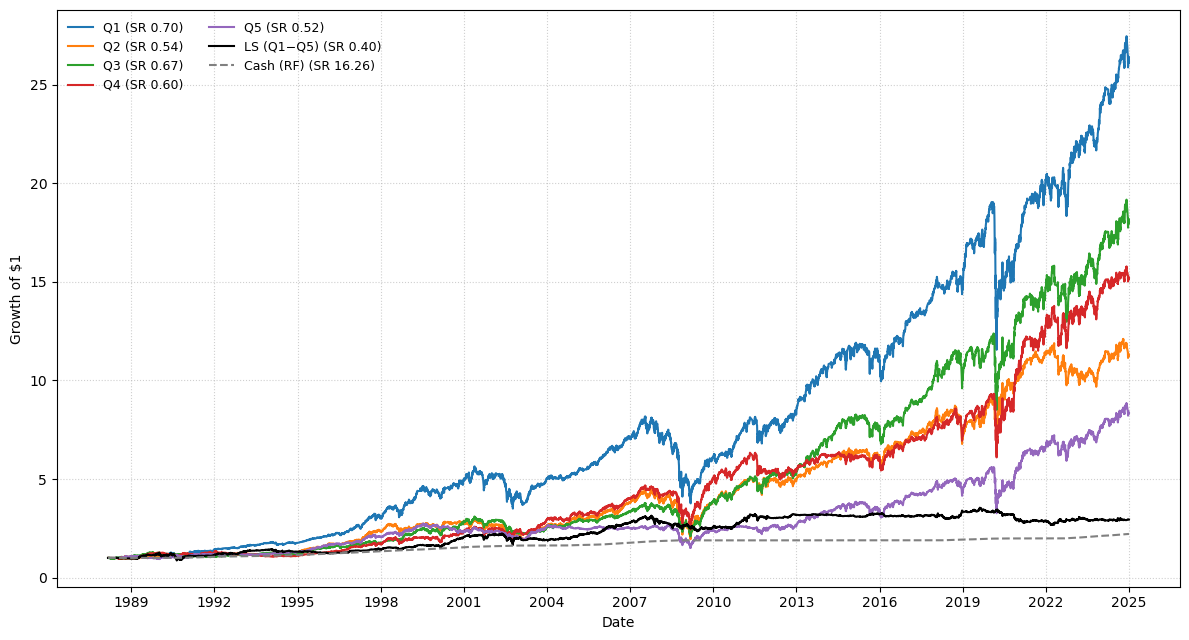

In [6]:
# ============================================
# FINAL METRICS w/ CASH BENCHMARK 
# ============================================
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates_np = np.array(q_df[1]["date"].to_list())                  
series   = {f"Q{q}": np.array(q_df[q]["ret"], dtype=float) for q in range(1, 6)}
ls       = np.array(ls_df["ret_ls"], dtype=float)


try:
    _ = cash_df  
except NameError:
    try:
        
        cash_df = ff6.select(["date", pl.col("RF").alias("ret_cash")])
    except NameError as e:
        raise RuntimeError("Provide either `cash_df` (date, ret_cash) or `ff6` with an 'RF' column.") from e

dates_list = [pd.Timestamp(d).date() for d in dates_np]
cash_on_grid = (
    pl.DataFrame({"date": pl.Series("date", dates_list, dtype=pl.Date)})
      .join(cash_df, on="date", how="left")
      .with_columns(pl.col("ret_cash").fill_null(0.0)) 
      .sort("date")
)
cash = np.array(cash_on_grid["ret_cash"], dtype=float)


def ann_sr(x):
    s = np.nanstd(x, ddof=0)
    return float((np.nanmean(x)/s)*np.sqrt(252.0)) if s > 0 else np.nan

def ann_ret(x):
    n = x.size
    return float((1 + np.nan_to_num(x)).prod()**(252.0/max(n, 1)) - 1.0) if n > 0 else np.nan

def ann_vol(x):
    return float(np.nanstd(x, ddof=0) * np.sqrt(252.0))

def max_dd(x):
    eq = np.cumprod(1.0 + np.nan_to_num(x))
    dd = eq / np.maximum.accumulate(eq) - 1.0
    return float(np.min(dd)) if dd.size else np.nan

def corr(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.corrcoef(a[m], b[m])[0, 1]) if m.sum() >= 3 else np.nan

def cum(x):
    return np.cumprod(1.0 + np.nan_to_num(x))

rows = {}
for q in range(1, 6):
    x = series[f"Q{q}"]
    rows[f"Q{q}"] = {
        "Ann. Return": ann_ret(x),
        "Ann. Vol":    ann_vol(x),
        "Ann. Sharpe": ann_sr(x),
        "Corr vs Cash": corr(x, cash),
        "Max DD":      max_dd(x),
        "N days":      int(x.size),
    }

rows["LS (Q1−Q5)"] = {
    "Ann. Return": ann_ret(ls),
    "Ann. Vol":    ann_vol(ls),
    "Ann. Sharpe": ann_sr(ls),
    "Corr vs Cash": corr(ls, cash[:ls.size]), 
    "Max DD":      max_dd(ls),
    "N days":      int(ls.size),
}

rows["Cash (RF)"] = {
    "Ann. Return": ann_ret(cash),
    "Ann. Vol":    ann_vol(cash),
    "Ann. Sharpe": ann_sr(cash),
    "Corr vs Cash": np.nan,  
    "Max DD":      max_dd(cash),
    "N days":      int(cash.size),
}

summary_df = pd.DataFrame(rows).T.loc[['Q1','Q2','Q3','Q4','Q5','LS (Q1−Q5)','Cash (RF)']]
print("\n=== Summary (daily, full sample; benchmark: Cash) ===")
print(summary_df.round(4))

plt.figure(figsize=(12, 6.5))
colors = {1:"tab:blue", 2:"tab:orange", 3:"tab:green", 4:"tab:red", 5:"tab:purple"}

for q in [1, 2, 3, 4, 5]:
    x = series[f"Q{q}"]
    plt.plot(dates_np, cum(x), color=colors[q], label=f"Q{q} (SR {ann_sr(x):.2f})")

plt.plot(dates_np, cum(ls), color="black", label=f"LS (Q1−Q5) (SR {ann_sr(ls):.2f})")
plt.plot(dates_np, cum(cash), color="gray", ls="--", label=f"Cash (RF) (SR {ann_sr(cash):.2f})")

plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.grid(ls=":", alpha=.6)
ax = plt.gca()
ax.legend(frameon=False, fontsize=9, ncols=2)
ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


In [7]:
import polars as pl
import numpy as np
import pandas as pd

for name in ["ret_wide", "state_var", "ff6"]:
    assert name in globals(), f"{name} not found. Load/define it first."

if "month" not in ret_wide.columns:
    ret_wide_m = ret_wide.with_columns(pl.col("date").dt.strftime("%Y-%m").alias("month"))
else:
    ret_wide_m = ret_wide

daily_cols = [c for c in ret_wide_m.columns if c not in ("date","month")]
ret_wide_m = ret_wide_m.rename({c: str(c) for c in daily_cols})
daily_cols = [str(c) for c in daily_cols]

print("ret_wide_m shape:", ret_wide_m.shape)
print("daily columns (first 5):", daily_cols[:5])
print(ret_wide_m.head(3))

assert "month" in state_var.columns, "state_var must have a 'month' column"
macro_cols = [c for c in state_var.columns if c != "month"]
print("state_var months:", state_var["month"].head(3).to_list(), "…")
print("macro features:", macro_cols)

FF_COLS = ["Mkt-RF","SMB","HML","RMW","CMA","Mom","RF"]
for c in FF_COLS:
    assert c in ff6.columns, f"Missing {c} in ff6"


ret_wide_m shape: (10080, 165)
daily columns (first 5): ['10145', '10233', '10401', '10604', '10890']
shape: (3, 165)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────┬─────────┐
│ date       ┆ 10145     ┆ 10233     ┆ 10401     ┆ … ┆ 66800     ┆ 74617     ┆ 68419 ┆ month   │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---   ┆ ---     │
│ date       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64   ┆ str     │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════╪═════════╡
│ 1985-01-02 ┆ -0.014493 ┆ -0.011881 ┆ -0.012821 ┆ … ┆ -0.011009 ┆ -0.025641 ┆ null  ┆ 1985-01 │
│ 1985-01-03 ┆ 0.0       ┆ -0.012024 ┆ 0.012987  ┆ … ┆ -0.009276 ┆ -0.039474 ┆ null  ┆ 1985-01 │
│ 1985-01-04 ┆ 0.003676  ┆ -0.006085 ┆ 0.00641   ┆ … ┆ -0.007491 ┆ 0.006849  ┆ null  ┆ 1985-01 │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────┴─────────┘
state_var

In [8]:

import numpy as np
import pandas as pd
import polars as pl



DAILY_COLS = [c for c in ret_wide_m.columns if c not in ("date","month")]

dates_np = np.array(q_df[1]["date"].to_list(), dtype="datetime64[D]")
cash_on_grid = (
    pl.DataFrame({"date": [pd.Timestamp(d).date() for d in dates_np]})
      .join(ff6.select(["date","RF"]), on="date", how="left")
      .rename({"RF":"ret_cash"})
      .with_columns(pl.col("ret_cash").fill_null(0.0))
      .sort("date")
)
cash = np.array(cash_on_grid["ret_cash"], dtype=float)

series = {f"Q{q}": np.array(q_df[q]["ret"], dtype=float) for q in range(1,6)}
ls     = np.array(ls_df["ret_ls"], dtype=float)

def ann_sr(x):
    s = np.nanstd(x, ddof=0); m = np.nanmean(x)
    return float((m/s)*np.sqrt(252.0)) if s>0 else np.nan

def ann_ret(x):
    n = x.size
    return float((1 + np.nan_to_num(x)).prod()**(252.0/max(n,1)) - 1.0) if n>0 else np.nan

def ann_vol(x): return float(np.nanstd(x, ddof=0)*np.sqrt(252.0))
def max_dd(x):
    eq = np.cumprod(1.0 + np.nan_to_num(x)); dd = eq/np.maximum.accumulate(eq) - 1.0
    return float(np.min(dd)) if dd.size else np.nan

def info_ratio(x, b):  # IR vs benchmark b (cash)
    diff = x - b
    s = np.nanstd(diff, ddof=0)
    return float((np.nanmean(diff)/s)*np.sqrt(252.0)) if s>0 else np.nan

def tstat_mean(x):
    m  = np.nanmean(x); s = np.nanstd(x, ddof=0); n = np.isfinite(x).sum()
    return float(m/(s/np.sqrt(n))) if (s>0 and n>1) else np.nan

def hit_rate(x):  return float(np.nanmean(x > 0.0))
def skewness(x):
    x = x[np.isfinite(x)]
    if x.size < 3: return np.nan
    m = x.mean(); s = x.std(ddof=0)
    return float(np.mean(((x-m)/s)**3)) if s>0 else np.nan

rows = {}
for q in range(1,6):
    x = series[f"Q{q}"]
    rows[f"Q{q}"] = {
        "Ann. Return": ann_ret(x),
        "Ann. Vol":    ann_vol(x),
        "Ann. Sharpe": ann_sr(x),
        "Info Ratio vs Cash": info_ratio(x, cash),
        "t-stat (mean)": tstat_mean(x),
        "Hit rate":     hit_rate(x),
        "Skewness":     skewness(x),
        "Max DD":       max_dd(x),
        "N days":       int(x.size),
    }

rows["LS (Q1−Q5)"] = {
    "Ann. Return": ann_ret(ls),
    "Ann. Vol":    ann_vol(ls),
    "Ann. Sharpe": ann_sr(ls),
    "Info Ratio vs Cash": info_ratio(ls, cash[:ls.size]),
    "t-stat (mean)": tstat_mean(ls),
    "Hit rate":     hit_rate(ls),
    "Skewness":     skewness(ls),
    "Max DD":       max_dd(ls),
    "N days":       int(ls.size),
}
rows["Cash (RF)"] = {
    "Ann. Return": ann_ret(cash),
    "Ann. Vol":    ann_vol(cash),
    "Ann. Sharpe": ann_sr(cash),
    "Info Ratio vs Cash": np.nan,
    "t-stat (mean)": tstat_mean(cash),
    "Hit rate":     hit_rate(cash),
    "Skewness":     skewness(cash),
    "Max DD":       max_dd(cash),
    "N days":       int(cash.size),
}

summary_metrics = pd.DataFrame(rows).T.loc[["Q1","Q2","Q3","Q4","Q5","LS (Q1−Q5)","Cash (RF)"]]
print("\n=== PERFORMANCE METRICS (daily, full; cash benchmark) ===")
summary_metrics.round(4)




=== PERFORMANCE METRICS (daily, full; cash benchmark) ===


,Ann. Return,Ann. Vol,Ann. Sharpe,Info Ratio vs Cash,t-stat (mean),Hit rate,Skewness,Max DD,N days
Q1,0.0969,0.1466,0.7046,0.5507,4.1852,0.5387,-0.4282,-0.5391,8890.0
Q2,0.0711,0.1480,0.5381,0.3856,3.1961,0.5291,-0.1530,-0.5629,8890.0
Q3,0.0854,0.1364,0.6689,0.5034,3.9731,0.5367,-0.2691,-0.4464,8890.0
Q4,0.0801,0.1460,0.6011,0.4465,3.5704,0.5273,-0.2907,-0.4769,8890.0
Q5,0.0619,0.1322,0.5209,0.3501,3.0940,0.5186,-0.4721,-0.4498,8890.0
LS (Q1−Q5),0.0311,0.0870,0.3959,0.1365,2.3513,0.5117,-0.0887,-0.3130,8890.0
Cash (RF),0.0228,0.0014,16.2620,NaN,96.5880,0.5673,0.2673,0.0000,8890.0


In [9]:

def ols_with_tstats(y, X):  
    X_ = np.column_stack([np.ones(len(y)), X]) 
    beta, _, _, _ = np.linalg.lstsq(X_, y, rcond=None)
    resid = y - X_ @ beta
    n, k = X_.shape
    s2   = resid.T @ resid / max(n - k, 1)
    cov  = s2 * np.linalg.pinv(X_.T @ X_)        
    se   = np.sqrt(np.diag(cov))
    t    = beta / se
    r2   = 1.0 - (resid @ resid) / np.sum((y - y.mean())**2) if n>k else np.nan
    return beta, t, r2

ff_on_grid = (
    pl.DataFrame({"date":[pd.Timestamp(d).date() for d in dates_np]})
      .join(ff6.select(["date","Mkt-RF","SMB","HML","RMW","CMA","Mom","RF"]), on="date", how="left")
      .drop_nulls(subset=["RF"])  # drop days with no FF
      .sort("date")
)

def regress_port(name, s_np):
    df = pl.DataFrame({
        "date": [pd.Timestamp(d).date() for d in dates_np],
        "ret":  s_np
    }).join(ff_on_grid, on="date", how="inner")

    y = (df["ret"] - df["RF"]).to_numpy()
    X = df.select(["Mkt-RF","SMB","HML","RMW","CMA","Mom"]).to_numpy()
    msk = np.isfinite(y) & np.isfinite(X).all(axis=1)
    y, X = y[msk], X[msk]
    if y.size < 30:
        return name, None

    beta, t, r2 = ols_with_tstats(y, X)
    out = pd.Series({
        "alpha": beta[0], "t_alpha": t[0],
        "beta_Mkt": beta[1], "t_Mkt": t[1],
        "beta_SMB": beta[2], "t_SMB": t[2],
        "beta_HML": beta[3], "t_HML": t[3],
        "beta_RMW": beta[4], "t_RMW": t[4],
        "beta_CMA": beta[5], "t_CMA": t[5],
        "beta_Mom": beta[6], "t_Mom": t[6],
        "R2": r2, "N": y.size
    })
    return name, out

reg_rows = {}
for q in range(1,6):
    nm, row = regress_port(f"Q{q}", series[f"Q{q}"])
    reg_rows[nm] = row
nm, row = regress_port("LS (Q1−Q5)", ls)
reg_rows[nm] = row

reg_table = pd.DataFrame(reg_rows).T.loc[["Q1","Q2","Q3","Q4","Q5","LS (Q1−Q5)"]]
print("\n=== FF6 REGRESSIONS (daily excess returns) ===")
reg_table.round(4)



=== FF6 REGRESSIONS (daily excess returns) ===


,alpha,t_alpha,beta_Mkt,t_Mkt,beta_SMB,t_SMB,beta_HML,t_HML,beta_RMW,t_RMW,beta_CMA,t_CMA,beta_Mom,t_Mom,R2,N
Q1,-0.0000,-0.1400,0.8182,230.1206,-0.0435,-6.1828,0.0968,12.3487,0.1298,14.0722,0.2019,18.6543,-0.0840,-19.7521,0.8808,8213.0
Q2,-0.0001,-2.0330,0.7958,191.2467,0.0076,0.9210,0.1170,12.7459,0.1517,14.0562,0.2265,17.8855,-0.1393,-27.9910,0.8394,8213.0
Q3,-0.0000,-1.1847,0.7340,179.5362,0.0544,6.7263,0.1499,16.6238,0.1258,11.8650,0.1929,15.5020,-0.0595,-12.1777,0.8173,8213.0
Q4,-0.0001,-1.4465,0.7727,172.8463,0.0718,8.1073,0.1999,20.2687,0.0961,8.2855,0.1934,14.2089,-0.0900,-16.8293,0.8107,8213.0
Q5,-0.0001,-2.4793,0.6832,149.5666,0.0960,10.6160,0.1697,16.8443,0.1929,16.2812,0.1060,7.6243,-0.0676,-12.3721,0.7591,8213.0
LS (Q1−Q5),0.0000,0.2479,0.1350,25.7718,-0.1393,-13.4315,-0.0731,-6.3289,-0.0633,-4.6617,0.0962,6.0324,-0.0167,-2.6581,0.1150,8213.0


In [10]:

MONTHS_FOR_SIG = months_bt_use if 'months_bt_use' in globals() else months_bt

def monthly_signal_set(month_str, q):
    sig = signal_for_quintile(month_str, q)
    return {k for k,v in sig.items() if v != 0}, {k for k,v in sig.items() if v>0}, {k for k,v in sig.items() if v<0}

turnover = {f"Q{q}":[] for q in range(1,6)}
for i in range(len(MONTHS_FOR_SIG)-1):
    m0, m1 = MONTHS_FOR_SIG[i], MONTHS_FOR_SIG[i+1]
    for q in range(1,6):
        act0, long0, short0 = monthly_signal_set(m0, q)
        act1, long1, short1 = monthly_signal_set(m1, q)
        active = (act0 | act1)
        if not active:
            continue
        s0 = {k:(+1 if k in long0 else (-1 if k in short0 else 0)) for k in active}
        s1 = {k:(+1 if k in long1 else (-1 if k in short1 else 0)) for k in active}
        chg = sum(1 for k in active if s0[k] != s1[k])
        turnover[f"Q{q}"].append(chg/len(active))

turnover_table = pd.DataFrame({k: pd.Series(v).mean() for k,v in turnover.items()}, index=["Avg monthly turnover"]).T
print("\n=== TURNOVER (avg monthly, sign-change proxy) ===")
turnover_table.round(4)



C:\Users\kelvi\AppData\Local\Temp\ipykernel_34588\1915363832.py:153: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(sub, axis=0)



=== TURNOVER (avg monthly, sign-change proxy) ===


,Avg monthly turnover
Q1,0.0943
Q2,0.1398
Q3,0.1653
Q4,0.1842
Q5,0.1477



=== ALPHA DECAY — Q1 (preview) ===
   day   avg_ret       cum  n_obs
0    0  0.001729  1.001729    423
1    1  0.000965  1.002696    423
2    2  0.000500  1.003197    423
3    3  0.000355  1.003553    423
4    4  0.000215  1.003769    423
5    5  0.000241  1.004011    423
6    6 -0.000083  1.003928    423
7    7 -0.000105  1.003823    423
8    8  0.000529  1.004354    423
9    9  0.000658  1.005014    423


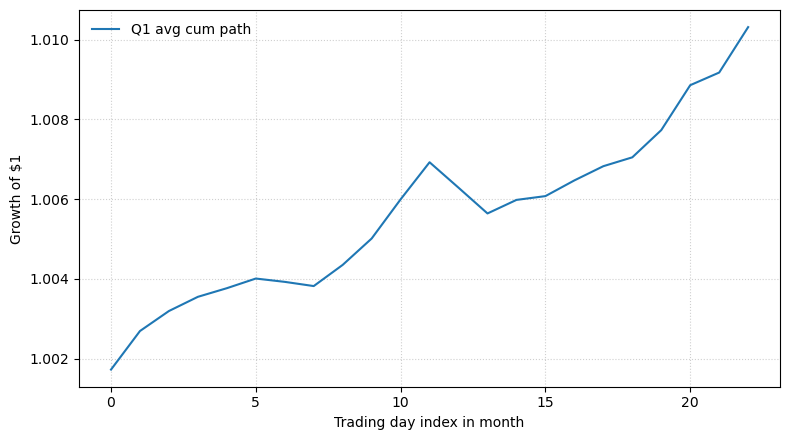

Half-life = 10 trading days (captured 58.1% of total alpha by then)


In [11]:
# -----------------------------
# 4) Alpha DECAY — Q1 only
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

date_month_map = ret_wide_m.select(["date", "month"]).unique()

def alpha_decay_q1(q1_df: pl.DataFrame, date_month_map: pl.DataFrame):
    """
    q1_df: Polars DF with columns ["date","ret"] for Q1 daily P&L.
    Returns: pandas DataFrame with columns [day, avg_ret, cum, n_obs]
    """
    df = (
        q1_df.join(date_month_map, on="date", how="left")
             .drop_nulls(["month"])
             .sort(["month", "date"])
             .with_columns((pl.col("date").cum_count().over("month") - 1).alias("day_idx"))
    )

    agg = (
        df.group_by("day_idx")
          .agg([
              pl.col("ret").mean().alias("avg_ret"),
              pl.len().alias("n_obs")
          ])
          .sort("day_idx")
    )

    avg  = np.array(agg["avg_ret"], dtype=float)
    path = (1.0 + np.nan_to_num(avg)).cumprod()

    out = pd.DataFrame({
        "day":    agg["day_idx"].to_list(),
        "avg_ret": avg,
        "cum":     path,
        "n_obs":   agg["n_obs"].to_list(),
    })
    return out

decay_q1 = alpha_decay_q1(q_df[1].select(["date","ret"]), date_month_map)

print("\n=== ALPHA DECAY — Q1 (preview) ===")
print(decay_q1.head(10).round(6))

# (optional) quick plot
plt.figure(figsize=(8,4.5))
plt.plot(decay_q1["day"], decay_q1["cum"], label="Q1 avg cum path")
plt.xlabel("Trading day index in month")
plt.ylabel("Growth of $1")
plt.grid(ls=":", alpha=.6)
plt.legend(frameon=False)
plt.tight_layout(); plt.show()


def alpha_half_life(decay_df: pd.DataFrame):

    total = decay_df["cum"].iloc[-1] - 1.0
    half  = 0.5 * total

    cum_excess = decay_df["cum"] - 1.0
    hit = np.where(cum_excess >= half)[0]

    if len(hit) == 0:
        return None, None  
    d = int(decay_df.loc[hit[0], "day"])
    captured = float(cum_excess.iloc[hit[0]] / total)
    return d, captured

hl_day, pct = alpha_half_life(decay_q1)
print(f"Half-life = {hl_day} trading days "
      f"(captured {pct:.1%} of total alpha by then)")



In [18]:
# =========================
# STRUCTURAL CHECKS (Q1..Q5 + Q1 details)
# =========================
import numpy as np
import pandas as pd
import polars as pl
GROSS_TARGET   = 1.0

FACTOR_LIST  = ["Mkt-RF","SMB","HML","RMW","CMA","Mom"]
WINDOW_DAYS  = 252         
MAX_WEIGHT_CAP = None  
month_dates_df = (
    ret_wide_m.select(["month","date"])
              .group_by("month")
              .agg(pl.col("date").sort())
)
MONTH_TO_DATES = {m: ds for m, ds in month_dates_df.iter_rows()}

ALL_DATES   = ret_wide_m.select("date").unique().sort("date")["date"].to_list()
DATE_TO_IDX = {d: i for i, d in enumerate(ALL_DATES)}

def last_trading_day(ym: str):
    ds = MONTH_TO_DATES.get(ym)
    return ds[-1] if ds else None

def window_dates_up_to(end_date, window_days: int) -> list:
    if end_date not in DATE_TO_IDX:
        prevs = [d for d in ALL_DATES if d <= end_date]
        if not prevs:
            return []
        end_date = prevs[-1]
    j = DATE_TO_IDX[end_date]
    i = max(0, j - window_days + 1)
    return ALL_DATES[i:j+1]

def simple_equal_weights_from_signal(
    s_dict: dict[str, int],
    gross_target: float = 1.0,
    cap: float | None = None
) -> np.ndarray:
    
    s = np.array([s_dict.get(c, 0) for c in daily_cols], dtype=int)
    N = s.size
    w = np.zeros(N, dtype=float)

    pos = (s > 0); neg = (s < 0)
    nL, nS = int(pos.sum()), int(neg.sum())

    if nL == 0 and nS == 0:
        return w

    if nL > 0 and nS > 0:
        w[pos] = +0.5 / nL
        w[neg] = -0.5 / nS
    elif nL > 0:
        w[pos] = +1.0 / nL
    else:
        w[neg] = -1.0 / nS

    if cap is not None:
        w = np.clip(w, -cap, cap)

    gross = float(np.sum(np.abs(w)))
    if gross > 1e-12:
        w *= (gross_target / gross)
    else:
        w[:] = 0.0
    return w

def effective_breadth_from_weights(w: np.ndarray) -> float:
    w = np.nan_to_num(w, nan=0.0)
    s = np.sum(np.abs(w))
    if s <= 0:
        return 0.0
    w = w / s    
    hhi = float(np.sum(w**2))
    return (1.0 / hhi) if hhi > 0 else 0.0

def check_monotonicity(summary_df: pd.DataFrame):
    from scipy.stats import spearmanr
    sharpe_by_q = [summary_df.loc[f"Q{q}","Ann. Sharpe"] for q in range(1,6)]
    rho, pval = spearmanr(range(1,6), sharpe_by_q)
    print("\n[Monotonicity] Spearman rho (Quantile index vs Sharpe): "
          f"{rho:.3f}  (p={pval:.3g})")
    return rho, pval

def q1_breadth_stats(months_bt, daily_cols, GROSS_TARGET=1.0, MAX_WEIGHT_CAP=None):
    eff_breadth, n_active = [], []
    for i in range(0, len(months_bt)-1):
        cur, nxt = months_bt[i], months_bt[i+1]
        sig = signal_for_quintile(cur, 1)
        w   = simple_equal_weights_from_signal(sig, gross_target=GROSS_TARGET, cap=MAX_WEIGHT_CAP)
        eff_breadth.append(effective_breadth_from_weights(w))
        n_active.append(int(np.sum(np.array([sig.get(c,0) for c in daily_cols]) != 0)))
    out = pd.DataFrame({
        "eff_breadth": eff_breadth,
        "n_active": n_active
    })
    print("\n[Breadth] Q1  →  "
          f"Mean eff. breadth={out['eff_breadth'].mean():.1f}, "
          f"Median eff. breadth={out['eff_breadth'].median():.1f}, "
          f"Mean #active={out['n_active'].mean():.0f}")
    return out

def exposure_drift_q1(q_df, ff6):
    q1_daily = q_df[1].select(["date","ret"])
    dm = ret_wide_m.select(["date","month"]).unique()
    q1m = (
        q1_daily.join(dm, on="date", how="left")
                .group_by("month")
                .agg(((1 + pl.col("ret")).product() - 1.0).alias("ret_m"))
                .sort("month")
    )
    ff6m = (
        ff6.select(["date"] + FACTOR_LIST + ["RF"])
           .with_columns(pl.col("date").dt.strftime("%Y-%m").alias("month"))
           .group_by("month")
           .agg([pl.col(f).mean().alias(f) for f in FACTOR_LIST + ["RF"]])
           .sort("month")
    )
    j = q1m.join(ff6m, on="month", how="inner")
    if j.height < (len(FACTOR_LIST)+10):
        print("\n[Exposure Drift] Not enough overlapping monthly points.")
        return None

    y = j["ret_m"].to_numpy() - j["RF"].to_numpy()
    X = j.select(FACTOR_LIST).to_numpy()  # (T x K)
    X_ = np.column_stack([np.ones(len(y)), X])
    beta = np.linalg.lstsq(X_, y, rcond=None)[0]
    yhat = X_ @ beta
    resid = y - yhat
    r2 = 1.0 - (resid @ resid) / ((y - y.mean()) @ (y - y.mean()))
    coefs = pd.Series(beta, index=["const"]+FACTOR_LIST)
    print("\n[Exposure Drift] OLS on monthly excess returns:")
    print(coefs.round(4))
    print(f"R^2 = {r2:.3f}  | T = {len(y)} months")
    return coefs, r2

def rolling_daily_betas(window_dates, factors_df, ret_wide_m, daily_cols):

    if not window_dates:
        return np.zeros((len(daily_cols), len(FACTOR_LIST))), 0

    ff = factors_df.filter(pl.col("date").is_in(window_dates)).select("date").unique().sort("date")
    ff_dates = set(ff["date"].to_list())

    rr = (ret_wide_m
          .select(["date"])
          .filter(pl.col("date").is_in(window_dates))
          .unique()
          .sort("date"))
    rr_dates = set(rr["date"].to_list())

    common_dates = sorted(ff_dates & rr_dates)
    if not common_dates:
        return np.zeros((len(daily_cols), len(FACTOR_LIST))), 0

    ff_aligned = factors_df.filter(pl.col("date").is_in(common_dates)).sort("date")
    X  = ff_aligned.select(FACTOR_LIST).to_numpy()            
    rf = ff_aligned.select("RF").to_numpy().reshape(-1)        

    R = (ret_wide_m.filter(pl.col("date").is_in(common_dates))
                     .sort("date")
                     .select(daily_cols)
                     .to_numpy())                           

    T, K = X.shape
    N    = R.shape[1]
    if R.shape[0] != T:
        return np.zeros((len(daily_cols), len(FACTOR_LIST))), 0

    B = np.zeros((N, K))
    for j in range(N):
        y = R[:, j]
        m = np.isfinite(y) & np.isfinite(rf)                   
        m = m & np.all(np.isfinite(X), axis=1)
        if m.sum() < (K + 10):
            continue
        y_ex = y[m] - rf[m]
        X_m  = X[m, :]
        G = X_m.T @ X_m + 1e-10 * np.eye(K)
        try:
            beta = np.linalg.solve(G, X_m.T @ y_ex)
        except np.linalg.LinAlgError:
            beta = np.linalg.pinv(G) @ (X_m.T @ y_ex)
        B[j, :] = beta

    return B, int(np.sum(np.ones(len(common_dates))))  


def signal_overlap_long_only(q_df, ff6, ret_wide_m, daily_cols, months_bt,
                             window_days=WINDOW_DAYS):
    fdf = ff6.select(["date"] + FACTOR_LIST + ["RF"])

    q1 = q_df[1].select(["date","ret"]).sort("date")
    q1_dates = set(q1["date"].to_list())

    rets_by_factor = {f: [] for f in FACTOR_LIST}
    q1_rets_all    = []

    q1_map = dict(q1.iter_rows())

    for i in range(0, len(months_bt)-1):
        cur, nxt = months_bt[i], months_bt[i+1]
        cur_end = last_trading_day(cur)
        if cur_end is None:
            continue
        win_dates = window_dates_up_to(cur_end, window_days)
        if not win_dates:
            continue

        B, T = rolling_daily_betas(win_dates, fdf, ret_wide_m, daily_cols)
        if T < (len(FACTOR_LIST)+10):
            continue

        rows_tp1 = ret_wide_m.filter(pl.col("month")==nxt)
        if rows_tp1.height == 0:
            continue
        M     = rows_tp1.select(daily_cols).to_numpy()  # (D, N)
        dates = rows_tp1["date"].to_list()

        for k, fac in enumerate(FACTOR_LIST):
            bk = B[:, k]
            w  = np.maximum(bk, 0.0)
            s  = w.sum()
            if s <= 0:
                continue
            w /= s
            with np.errstate(invalid='ignore'):
                dr = np.nansum(M * w[None, :], axis=1)
            rets_by_factor[fac].extend(zip(dates, dr.tolist()))

        q1_rets_all.extend([(d, q1_map.get(d, np.nan)) for d in dates if d in q1_dates])

    q1_df_aligned = pd.DataFrame(q1_rets_all, columns=["date","q1"]).dropna().drop_duplicates("date").set_index("date").sort_index()
    corrs = {}
    for fac, pairs in rets_by_factor.items():
        if not pairs:
            corrs[fac] = np.nan
            continue
        df = pd.DataFrame(pairs, columns=["date", fac]).dropna().drop_duplicates("date").set_index("date").sort_index()
        common = q1_df_aligned.join(df, how="inner")
        if common.empty or common.shape[0] < 20:
            corrs[fac] = np.nan
        else:
            corr = float(np.corrcoef(common["q1"].values, common[fac].values)[0,1])
            corrs[fac] = corr

    corr_s = pd.Series(corrs).sort_values(ascending=False)
    print("\n[Signal Overlap] Correlation of Q1 daily returns with LO factor proxies:")
    print(corr_s.round(3))
    return corr_s


_ = check_monotonicity(summary_df)
breadth_q1 = q1_breadth_stats(months_bt, daily_cols, GROSS_TARGET=GROSS_TARGET, MAX_WEIGHT_CAP=MAX_WEIGHT_CAP)
_ = exposure_drift_q1(q_df, ff6)
_ = signal_overlap_long_only(q_df, ff6, ret_wide_m, daily_cols, months_bt, window_days=WINDOW_DAYS)



[Monotonicity] Spearman rho (Quantile index vs Sharpe): -0.700  (p=0.188)

[Breadth] Q1  →  Mean eff. breadth=58.3, Median eff. breadth=54.2, Mean #active=139

[Exposure Drift] OLS on monthly excess returns:
const      0.0018
Mkt-RF    18.1356
SMB        0.2106
HML        2.7054
RMW        1.8981
CMA        4.0266
Mom       -2.0042
dtype: float64
R^2 = 0.853  | T = 391 months

[Signal Overlap] Correlation of Q1 daily returns with LO factor proxies:
Mkt-RF    0.945
CMA       0.877
RMW       0.872
HML       0.841
SMB       0.789
Mom       0.762
dtype: float64


In [14]:
# =========================
# ROBUSTNESS PIPELINE 
# =========================
import numpy as np, pandas as pd, polars as pl, warnings, math
warnings.filterwarnings("ignore", category=RuntimeWarning)

TRADING_DAYS = 252

def to_series(poly_df: pl.DataFrame, col: str = "ret") -> pd.Series:
    df = poly_df.select(["date", col]).to_pandas()
    s = df.set_index("date")[col].astype(float).sort_index()
    s = s[~s.index.duplicated(keep="first")]
    return s

def ann_sr(x: np.ndarray) -> float:
    s = np.nanstd(x, ddof=0)
    return float((np.nanmean(x)/s)*np.sqrt(TRADING_DAYS)) if s > 1e-15 else np.nan

def split_indices(n: int, k: int) -> list[tuple[int,int]]:
    edges = np.linspace(0, n, k+1, dtype=int)
    return [(edges[i], edges[i+1]) for i in range(k)]

def block_bootstrap(x: np.ndarray, block_len: int, n_samples: int) -> np.ndarray:
    """Return array of shape (n_samples,) of bootstrapped Sharpe ratios."""
    n = len(x)
    n_blocks = math.ceil(n / block_len)
    srs = np.empty(n_samples, dtype=float)
    for b in range(n_samples):
        idx = []
        for _ in range(n_blocks):
            start = np.random.randint(0, max(n - block_len + 1, 1))
            idx.extend(range(start, min(start + block_len, n)))
        xb = x[np.array(idx[:n])]
        srs[b] = ann_sr(xb)
    return srs

def circular_shift(x: np.ndarray, k: int) -> np.ndarray:
    if x.size == 0: return x
    k = k % x.size
    return np.concatenate([x[-k:], x[:-k]]) if k else x.copy()

def subperiod_consistency(q_df: dict[int, pl.DataFrame], n_splits: int = 4) -> pd.DataFrame:
    rows = []
    for q in range(1, 6):
        s = to_series(q_df[q], "ret")
        dates = s.index.values
        x = s.values
        if x.size == 0: 
            continue
        for i, (a, b) in enumerate(split_indices(len(x), n_splits), start=1):
            sub = x[a:b]
            if sub.size < 30: 
                continue
            rows.append({"Bucket": f"Q{q}", "Split": i, "Sharpe": ann_sr(sub)})
    return pd.DataFrame(rows)

def calendar_consistency(q_df: dict[int, pl.DataFrame]) -> pd.DataFrame:
    """Sharpe by calendar bucket: pre-2008, 2008-crisis, post-crisis to 2019, 2020+."""
    rows = []
    cuts = [
        ("pre-2008", ("1900-01-01", "2007-12-31")),
        ("GFC-2008", ("2008-01-01", "2009-12-31")),
        ("2010-2019", ("2010-01-01", "2019-12-31")),
        ("2020+",    ("2020-01-01", "2100-12-31")),
    ]
    for q in range(1,6):
        s = to_series(q_df[q], "ret")
        for name, (lo, hi) in cuts:
            sub = s.loc[lo:hi].values
            if sub.size < 30: continue
            rows.append({"Bucket": f"Q{q}", "Period": name, "Sharpe": ann_sr(sub)})
    return pd.DataFrame(rows)

# ---------- 2) Monte Carlo + Block Bootstrap ----------
def mc_shuffle(q_df: dict[int, pl.DataFrame], n_iter: int = 2000, seed: int | None = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    rows = []
    for q in range(1,6):
        x = to_series(q_df[q], "ret").values
        if x.size < 30: 
            continue
        sr_real = ann_sr(x)
        srs = [ann_sr(rng.permutation(x)) for _ in range(n_iter)]
        p = float(np.mean(np.array(srs) >= sr_real))
        rows.append({"Bucket": f"Q{q}", "Sharpe_real": sr_real, "Null_mean": float(np.mean(srs)), "p_value": p})
    return pd.DataFrame(rows)

def mc_block_bootstrap(q_df: dict[int, pl.DataFrame], block_len: int = 10, n_iter: int = 1000, seed: int | None = 123) -> pd.DataFrame:
    np.random.seed(seed)
    rows = []
    for q in range(1,6):
        x = to_series(q_df[q], "ret").values
        if x.size < 30: 
            continue
        sr_real = ann_sr(x)
        srs = block_bootstrap(x, block_len=block_len, n_samples=n_iter)
        p = float(np.mean(srs >= sr_real))
        rows.append({"Bucket": f"Q{q}", "Sharpe_real": sr_real, f"BB_mean(L={block_len})": float(np.mean(srs)), "p_value": p})
    return pd.DataFrame(rows)

# ---------- 3) Perturbation tests ----------
def perturb_lag_and_jitter(q_df: dict[int, pl.DataFrame],
                           lags: list[int] = [1,2,3,5],
                           jitters_bps: list[float] = [0.0, 0.5, 1.0, 2.0],
                           seed: int | None = 7) -> pd.DataFrame:
    """
    lags in trading days (1 = your current), jitters_bps = std dev in basis points added to returns.
    """
    rng = np.random.default_rng(seed)
    rows = []
    for q in range(1,6):
        s = to_series(q_df[q], "ret").sort_index()
        x_full = s.values
        for L in lags:
            x = x_full[L-1:] if L>1 else x_full.copy()
            if x.size < 30: 
                continue
            for jb in jitters_bps:
                sigma = float(jb) / 1e4  # bps to return space
                noise = rng.normal(0.0, sigma, size=x.size) if sigma>0 else 0.0
                sr = ann_sr(x + noise)
                rows.append({"Bucket": f"Q{q}", "Lag_days": L, "Jitter_bps": jb, "Sharpe": sr})
    return pd.DataFrame(rows)

def perturb_skip_days(q_df: dict[int, pl.DataFrame], skips: list[int] = [2,3,5]) -> pd.DataFrame:
    """
    Downsample by keeping every k-th day (simulates execution frictions / lower turnover).
    """
    rows = []
    for q in range(1,6):
        x = to_series(q_df[q], "ret").values
        for k in skips:
            if x.size // k < 30: 
                continue
            sr = ann_sr(x[::k])
            rows.append({"Bucket": f"Q{q}", "Keep_every_k_days": k, "Sharpe": sr})
    return pd.DataFrame(rows)

def perturb_circular_shift(q_df: dict[int, pl.DataFrame], shifts: list[int] = [1,5,10,21]) -> pd.DataFrame:
    """
    Circularly shift the return series (keeps distribution; probes timing sensitivity).
    """
    rows = []
    for q in range(1,6):
        x = to_series(q_df[q], "ret").values
        if x.size < 30: continue
        for k in shifts:
            sr = ann_sr(circular_shift(x, k))
            rows.append({"Bucket": f"Q{q}", "Shift_days": k, "Sharpe": sr})
    return pd.DataFrame(rows)

# =========================
# RUN THE PIPELINE
# =========================

# 1) Sub-periods
sub_eq   = subperiod_consistency(q_df, n_splits=4)
sub_cal  = calendar_consistency(q_df)
print("\n=== Sub-period consistency (equal splits) ===")
print(sub_eq.pivot(index="Bucket", columns="Split", values="Sharpe").round(3))
print("\n=== Sub-period consistency (calendar regimes) ===")
print(sub_cal.pivot(index="Bucket", columns="Period", values="Sharpe").round(3))

# 2) Monte Carlo & Block Bootstrap
mc_perm  = mc_shuffle(q_df, n_iter=2000)
mc_block = mc_block_bootstrap(q_df, block_len=10, n_iter=1000)
print("\n=== Monte Carlo (random permutation) ===")
print(mc_perm.round(3))
print("\n=== Block Bootstrap (len=10) ===")
print(mc_block.round(3))

# 3) Perturbations
pert_lj  = perturb_lag_and_jitter(q_df, lags=[1,2,3,5], jitters_bps=[0.0,0.5,1.0,2.0])
pert_skip= perturb_skip_days(q_df, skips=[2,3,5])
pert_rot = perturb_circular_shift(q_df, shifts=[1,5,10,21])

print("\n=== Perturbation: lag & jitter (Sharpe) ===")
print(pert_lj.pivot_table(index=["Bucket","Lag_days"], columns="Jitter_bps", values="Sharpe").round(3))
print("\n=== Perturbation: keep every k-th day (Sharpe) ===")
print(pert_skip.pivot(index="Bucket", columns="Keep_every_k_days", values="Sharpe").round(3))
print("\n=== Perturbation: circular shift (Sharpe) ===")
print(pert_rot.pivot(index="Bucket", columns="Shift_days", values="Sharpe").round(3))



=== Sub-period consistency (equal splits) ===
Split       1      2      3      4
Bucket                            
Q1      1.244  0.788  0.404  0.750
Q2      0.931  0.512  0.419  0.609
Q3      0.718  0.663  0.653  0.743
Q4      0.688  0.762  0.392  0.729
Q5      0.939  0.417  0.304  0.675

=== Sub-period consistency (calendar regimes) ===
Period  2010-2019  2020+  GFC-2008  pre-2008
Bucket                                      
Q1          1.041  0.479    -0.245     0.915
Q2          0.759  0.406     0.049     0.688
Q3          0.997  0.577     0.233     0.708
Q4          0.590  0.614     0.343     0.766
Q5          0.780  0.519    -0.030     0.629

=== Monte Carlo (random permutation) ===
  Bucket  Sharpe_real  Null_mean  p_value
0     Q1        0.705      0.705    0.995
1     Q2        0.538      0.538    0.904
2     Q3        0.669      0.669    1.000
3     Q4        0.601      0.601    0.990
4     Q5        0.521      0.521    0.992

=== Block Bootstrap (len=10) ===
  Bucket  Shar

In [20]:
# -----------------------------
# 5) RUN BACKTEST (factor-orthogonalized weights)
# -----------------------------
import warnings
warnings.filterwarnings("ignore")

# Config for this loop
ADD_MKT_NEUTRAL = True   
USE_ORTHO       = True   
def regress_betas_for_window(dates_win,
                             ff6_df=ff6,
                             ret_panel=ret_wide_m,
                             cols=daily_cols,
                             factors=FACTOR_LIST,
                             ridge=1e-10):

    if not dates_win:
        return np.zeros((len(cols), len(factors))), 0

    ffw = (ff6_df
           .select(["date"] + factors + ["RF"])
           .filter(pl.col("date").is_in(dates_win))
           .drop_nulls(["date"])
           .unique()
           .sort("date"))
    ff_dates = set(ffw["date"].to_list())

    rrw = (ret_panel
           .select(["date"])
           .filter(pl.col("date").is_in(dates_win))
           .unique()
           .sort("date"))
    rr_dates = set(rrw["date"].to_list())

    common = sorted(ff_dates & rr_dates)
    if not common:
        return np.zeros((len(cols), len(factors))), 0

    ff_al = ff6_df.filter(pl.col("date").is_in(common)).sort("date")
    X  = ff_al.select(factors).to_numpy()                 
    rf = ff_al.select("RF").to_numpy().reshape(-1)        

    R = (ret_panel.filter(pl.col("date").is_in(common))
                     .sort("date")
                     .select(cols)
                     .to_numpy())                         

    T, K = X.shape
    N    = R.shape[1]
    if R.shape[0] != T:
        return np.zeros((len(cols), len(factors))), 0

    B = np.zeros((N, K))
    finite_X = np.all(np.isfinite(X), axis=1)
    finite_rf = np.isfinite(rf)

    for j in range(N):
        y = R[:, j]
        m = np.isfinite(y) & finite_rf & finite_X
        if m.sum() < (K + 10):
            continue
        y_ex = y[m] - rf[m]
        X_m  = X[m, :]
        G = X_m.T @ X_m + ridge * np.eye(K)
        try:
            beta = np.linalg.solve(G, X_m.T @ y_ex)
        except np.linalg.LinAlgError:
            beta = np.linalg.pinv(G) @ (X_m.T @ y_ex)
        B[j, :] = beta

    return B, len(common)

def factor_orthogonalized_weights(sig_dict, betas,
                                  gross_target=GROSS_TARGET,
                                  add_market_neutral=ADD_MKT_NEUTRAL,
                                  cap=MAX_WEIGHT_CAP):
    N, K = betas.shape
    s = np.array([sig_dict.get(c, 0) for c in daily_cols], dtype=float)

    w0 = np.zeros(N, dtype=float)
    pos, neg = (s > 0), (s < 0)
    nL, nS = int(pos.sum()), int(neg.sum())
    if nL > 0 and nS > 0:
        w0[pos] = +0.5 / nL
        w0[neg] = -0.5 / nS
    elif nL > 0:
        w0[pos] = +1.0 / nL
    elif nS > 0:
        w0[neg] = -1.0 / nS
    else:
        return w0

    if not USE_ORTHO:
        if cap is not None:
            w0 = np.clip(w0, -cap, cap)
        g = np.sum(np.abs(w0))
        return (w0 * (gross_target / g)) if g > 1e-12 else np.zeros_like(w0)

    C = np.column_stack([betas, np.ones(N)]) if add_market_neutral else betas
    CtC = C.T @ C
    try:
        CtC_inv = np.linalg.inv(CtC)
    except np.linalg.LinAlgError:
        CtC_inv = np.linalg.pinv(CtC)
    P = C @ CtC_inv @ C.T

    w = (np.eye(N) - P) @ w0
    if cap is not None:
        w = np.clip(w, -cap, cap)
        w = (np.eye(N) - P) @ w

    g = np.sum(np.abs(w))
    return (w * (gross_target / g)) if g > 1e-12 else np.zeros_like(w)

returns_by_q = {q: [] for q in range(1,6)}

for i in range(0, len(months_bt)-1):
    cur, nxt = months_bt[i], months_bt[i+1]

    rows_tp1 = ret_wide_m.filter(pl.col("month") == nxt)
    if rows_tp1.height == 0:
        continue
    M     = rows_tp1.select(daily_cols).to_numpy()  # (D, N)
    dates = rows_tp1["date"].to_list()

    if USE_ORTHO:
        cur_end   = last_trading_day(cur)
        if cur_end is None:
            continue
        win_dates = window_dates_up_to(cur_end, WINDOW_DAYS)
        B, ovlp   = regress_betas_for_window(win_dates)
        if ovlp < max(60, len(FACTOR_LIST)+10):
            continue
    else:
        B = np.zeros((len(daily_cols), len(FACTOR_LIST)))  # unused

    for q in range(1, 6):
        sig = signal_for_quintile(cur, q)
        w   = factor_orthogonalized_weights(sig, B)
        with np.errstate(invalid='ignore'):
            dr = np.nansum(M * w[None, :], axis=1)
        returns_by_q[q].extend(zip(dates, dr.tolist()))

q_df = {q: pl.DataFrame(returns_by_q[q], schema=["date","ret"]).sort("date") for q in range(1,6)}
common_dates = sorted(set.intersection(*[set(q_df[q]["date"].to_list()) for q in range(1,6)]) if all(q_df[q].height for q in range(1,6)) else set())
for q in range(1,6):
    q_df[q] = q_df[q].filter(pl.col("date").is_in(common_dates)).sort("date")

ls_df = (
    q_df[1].join(q_df[5], on="date", how="inner", suffix="_q5")
           .with_columns((pl.col("ret") - pl.col("ret_q5")).alias("ret_ls"))
           .select(["date","ret_ls"])
           .sort("date")
)

# -----------------------------
# 8) Summary metrics table
# -----------------------------
dates_np = np.array(common_dates, dtype="datetime64[D]")
series   = {f"Q{q}": np.array(q_df[q]["ret"], dtype=float) for q in range(1,6)}
ls       = np.array(ls_df["ret_ls"], dtype=float)



def corr(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.corrcoef(a[m], b[m])[0,1]) if m.sum() >= 3 else np.nan

rows = {}
for q in range(1,6):
    x = series[f"Q{q}"]
    rows[f"Q{q}"] = {
        "Ann. Return": ann_ret(x),
        "Ann. Vol":    ann_vol(x),
        "Ann. Sharpe": ann_sr(x),
        "Max DD":      max_dd(x),
        "N days":      int(x.size),
    }
rows["LS (Q1−Q5)"] = {
    "Ann. Return": ann_ret(ls),
    "Ann. Vol":    ann_vol(ls),
    "Ann. Sharpe": ann_sr(ls),
    "Max DD":      max_dd(ls),
    "N days":      int(ls.size),
}

summary_df = pd.DataFrame(rows).T
print("\n=== SUMMARY METRICS (Factor-neutral backtest) ===")
print(summary_df.round(4))



=== SUMMARY METRICS (Factor-neutral backtest) ===
            Ann. Return  Ann. Vol  Ann. Sharpe  Max DD  N days
Q1              -0.0031    0.0356      -0.0687 -0.2046  8150.0
Q2              -0.0057    0.0334      -0.1542 -0.2637  8150.0
Q3              -0.0044    0.0313      -0.1252 -0.1941  8150.0
Q4              -0.0028    0.0310      -0.0734 -0.2078  8150.0
Q5              -0.0096    0.0241      -0.3892 -0.3387  8150.0
LS (Q1−Q5)       0.0061    0.0424       0.1635 -0.1456  8150.0
